In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
######################################################
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt

2022-09-15 23:27:07.403687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 23:27:07.403710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Prepare dataset

## Load data

In [3]:
df = pd.read_csv('../data/data_preparation.csv', index_col=[0])
df=df.iloc[:-60]

## Fill missing data

In [4]:
def replace_val(df,date1,date2): #on remplace les NaN dans l intervalle de date
    for col in df.columns:
        imputer = KNNImputer(n_neighbors=7) # Instantiate a SimpleImputer object with your strategy of choice
        imputer.fit(df[[col]]) # Call the "fit" method on the object
        df[col] = imputer.transform(df[[col]]) # Call the "transform" method on the object

In [5]:
df['Date']=pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').asfreq('D')
replace_val(df,'2022-04-30','2022-05-06')

### Select relevant features

In [6]:
df.drop(columns=['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12',
       't - 13', 't - 14', 't - 15', 't - 16', 't - 17', 't - 18', 't - 19',
       't - 20', 't - 21', 't - 22', 't - 23', 't - 24', 't - 25', 't - 26',
       't - 27', 't - 28', 't - 29', 't - 30','sin365_1', 'cos365_1', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3','bank_holiday', 'school_holidays',
       'season','Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)',
       'TCH Thermique (%)', 'TCO Nucléaire (%)', 'TCH Nucléaire (%)',
       'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)',
       'TCH Solaire (%)', 'Column 30','Code INSEE région','sin_month', 'cos_month',
        'num_day',
        'YEAR', 'MONTH', 'DAY',
        'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN','PS', 'QV2M','WS10M','WS50M','RH2M','week_day' #temoin
        #'PRECTOTCORR' # PRECTOTCORR is bias-corrected total precipitation
        #'sin_day','cos_day'
                ],inplace=True)

In [7]:
df['id']='A'

In [8]:
df

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521,A
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490,A
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000,A
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490,A
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521,A
...,...,...,...,...,...,...
2022-03-07,273204.0,5.98,0.36,0.000000,1.000000,A
2022-03-08,280638.0,5.10,0.83,0.781831,0.623490,A
2022-03-09,270148.0,6.59,0.11,0.974928,-0.222521,A


In [9]:
nb_data_train = int(len(df)*0.6)
nb_data_val = int(len(df)*0.2)

In [10]:
N_test = 14 #on prédit les 14 derniers jours dans chaque dataframe

In [11]:
df_train=df.iloc[:nb_data_train]

In [12]:
df_test=df.iloc[-N_test:]

In [13]:
df_val = df[nb_data_train:nb_data_train+nb_data_val]

In [14]:
df_train

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521,A
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490,A
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000,A
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490,A
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521,A
...,...,...,...,...,...,...
2018-07-16,200204.0,23.23,8.66,0.000000,1.000000,A
2018-07-17,200997.0,25.79,0.00,0.781831,0.623490,A
2018-07-18,206508.0,26.06,0.00,0.974928,-0.222521,A


In [15]:
df_val

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2018-07-21,197361.0,23.79,7.19,-0.974928,-0.222521,A
2018-07-22,186130.0,23.29,0.07,-0.781831,0.623490,A
2018-07-23,204687.0,25.78,0.00,0.000000,1.000000,A
2018-07-24,210549.0,25.56,0.12,0.781831,0.623490,A
2018-07-25,214022.0,27.27,0.38,0.974928,-0.222521,A
...,...,...,...,...,...,...
2020-05-11,171255.0,14.02,13.12,0.000000,1.000000,A
2020-05-12,171605.0,15.05,0.05,0.781831,0.623490,A
2020-05-13,173495.0,16.50,2.15,0.974928,-0.222521,A


In [16]:
#df=df.copy()
#df['Consommation (MW)'].iloc[-N_test:]=0 ###Commenter cette ligne pour preuve du bon fonctionnement

In [17]:
exo_feature = ['T2M','PRECTOTCORR', 'sin_day', 'cos_day']

In [18]:
ds_train = PandasDataset(df_train, target="Consommation (MW)",feat_dynamic_real=exo_feature)
ds_val = PandasDataset(df_val, target="Consommation (MW)",feat_dynamic_real=exo_feature)

In [19]:
estimator = DeepAREstimator(
    freq=ds_train.freq, prediction_length=N_test, trainer=Trainer(epochs=6,learning_rate=0.0001),
    use_feat_dynamic_real=True,
    batch_size=16,
    num_layers=2,
    num_cells=40
)

predictor = estimator.train(ds_train,ds_val)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.52it/s, epoch=1/6, avg_epoch_loss=13.7]
1it [00:00, 33.48it/s, epoch=1/6, validation_avg_epoch_loss=12.8]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.01it/s, epoch=2/6, avg_epoch_loss=12.8]
1it [00:00, 34.34it/s, epoch=2/6, validation_avg_epoch_loss=12.1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.75it/s, epoch=3/6, avg_epoch_loss=12.1]
1it [00:00, 36.66it/s, epoch=3/6, validation_avg_epoch_loss=11.4]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.91it/s, epoch=4/6, avg

In [161]:
reduction=1000
ds = PandasDataset(df.iloc[:-reduction], target="Consommation (MW)",feat_dynamic_real=exo_feature)

In [162]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds,#dataset.test,  # test dataset
    predictor=predictor,  # predictor, réglé pour predire les N_test derniers jours du dataframe
    num_samples=100,  # number of sample paths we want for evaluation, is useful for confidence interval
)

In [163]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [164]:
# first entry of the time series list
ts_entry = tss[0]

#np.array(ts_entry[:5]).reshape(-1,) #Get first values

In [165]:
forecast_entry = forecasts[0]

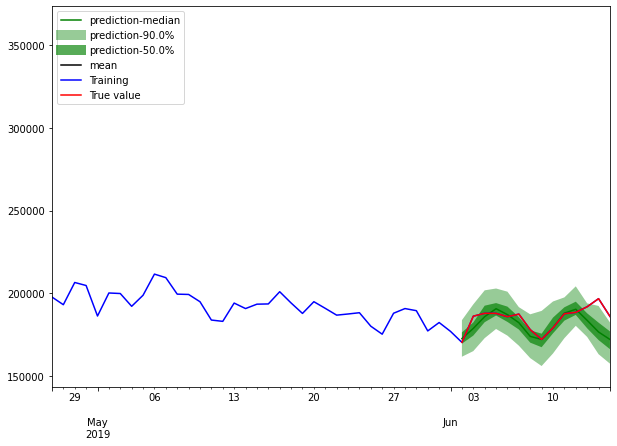

In [166]:
plot_length = N_test
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1] + ['true_value']
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

forecast_entry.plot(prediction_intervals=prediction_intervals, color="g",label='prediction')
plt.plot(forecast_entry.mean,label='mean',color='k')
plt.plot(df['Consommation (MW)'],label='Training',color='blue')
plt.plot(ts_entry[-plot_length:],label='True value',color='red')
plt.legend(loc="upper left")
plt.xlim(left=df['Consommation (MW)'].index[-reduction-50])
#plt.xlim(left=ts_entry[-plot_length:].index[0])
plt.show()

In [168]:
y_baseline = np.ones(N_test)*df['Consommation (MW)'].iloc[-reduction-N_test-1]
y_true = df['Consommation (MW)'].iloc[-reduction-N_test:-reduction]
y_pred = forecasts[0].median

In [174]:
print(f'mape(y_pred) = {mean_absolute_percentage_error(y_true, y_pred)}')
print(f'mape(y_baseline) = {mean_absolute_percentage_error(y_true, y_baseline)}')

mape(y_pred) = 0.026330367954772362
mape(y_baseline) = 0.049984032693122515
